In [ ]:
# ------------- follows new_pipeline ------------------

In [170]:
import MySQLdb as mdb
import sys
import nltk
import pandas as pd
from textstat.textstat import textstat
import copy
import numpy as np
import nltk
import string
from collections import Counter
from nltk.corpus import stopwords
import math 
import re
import nltk.stem.porter as porter



def read_in_mysql():
    ''' reads metadata and reviews databases into dataframes.
        Usage:  df_m, df_r = read_in_mysql()'''
    
    con = mdb.connect('localhost', 'insightUser', 'insight15', 'amazon_filtered_compact');
    cur = con.cursor()
    
    cur.execute("SELECT * FROM reviews")
    data = cur.fetchall()
    
    df_reviews = pd.DataFrame( [[ij for ij in i] for i in data] )
    df_reviews.rename(columns={0: 'Number',
                               1: 'asin', 
                               2: 'helpful-1',
                               3: 'helpful-2',
                               4: 'overall_score',
                               5: 'review_text',
                               6: 'reviewer_id',
                               7: 'review_summary'}, 
                      inplace=True);
    df_reviews.drop('Number',axis=1, inplace = True)
    
    cur.execute("SELECT * FROM metadata")
    data = cur.fetchall()

    df_metadata = pd.DataFrame( [[ij for ij in i] for i in data] )
    df_metadata.rename(columns={0: 'Number',
                                1: 'asin',
                                2: 'title',
                                3: 'imgUrl',
                                4: 'relevant_asins',
                                5: 'sales_rank'}, 
                       inplace=True);

    df_metadata.drop('Number',axis=1, inplace = True)

    con.close()
    
    return df_metadata, df_reviews

dfm, dfr = read_in_mysql()

In [171]:
dfm.drop('sales_rank', axis=1, inplace=True)


In [172]:
dfr.drop('helpful-1', axis=1, inplace=True)
dfr.drop('helpful-2', axis=1, inplace=True)
dfr.drop('reviewer_id', axis=1, inplace=True)

In [173]:
dfm['nrevs'] = 0.
dfm['ar_score'] = 0.
dfm['fk_score'] = 0.
dfm['nrevs_positive'] = 0
dfm['avg_rating'] = 0
dfm['adv_w'] = 0
dfm['intro_w'] = 0
dfm['winning_w'] = 0

dfm

,asin,title,imgUrl,relevant_asins,nrevs,ar_score,fk_score,nrevs_positive,avg_rating,adv_w,intro_w,winning_w
0,0005217954,MATERIALS SCI.+ENGR.:INTRO.-TE,http://ecx.images-amazon.com/images/I/21a3mxNH...,0470495901 0136077900 0136077919 0132215004 04...,0,0,0,0,0,0,0,0
1,0006970117,Materials Science and Engineering: An Introduc...,http://ecx.images-amazon.com/images/I/21CJVPZV...,0077366743 0136022308 1118116135 0470419970 04...,0,0,0,0,0,0,0,0
2,0007162219,Big Bang: The Origin of the Universe (P.S.),http://ecx.images-amazon.com/images/I/41e-Yg39...,0393325075 0385493622 0743264746 0385495323 04...,0,0,0,0,0,0,0,0
3,0021001286,"McGraw Hill Mathematics, Grade 5",http://ecx.images-amazon.com/images/I/51MfOvbr...,0022800387 0022446540 0021492670 0021001278 01...,0,0,0,0,0,0,0,0
4,0022321500,Basic Technical Drawing,http://ecx.images-amazon.com/images/I/519eyWSR...,0026856603 1588167593 0766816362 0026856603 00...,0,0,0,0,0,0,0,0
5,0022841377,Science - Grade 4: A Closer Look,http://ecx.images-amazon.com/images/I/312d8thy...,0022841385 0022841350 0022841369 1600325467 01...,0,0,0,0,0,0,0,0
6,0023364505,Principles and Applications of Geochemistry (2...,http://ecx.images-amazon.com/images/I/51J646CT...,0521516641 0321643186 0130882399 1405116528 B0...,0,0,0,0,0,0,0,0
7,0023544465,Solutions Manual Mechanics of materials,http://ecx.images-amazon.com/images/I/51v2ZQk1...,0133254429 0133254429 0136022308,0,0,0,0,0,0,0,0
8,0023544457,Mechanics of Materials/Book and Disk,http://ecx.images-amazon.com/images/I/21VV9VTR...,0130200050 0136077919 0130324728 0077275535 01...,0,0,0,0,0,0,0,0
9,0023619384,Semiconductor Devices,http://ecx.images-amazon.com/images/I/51tsRqY%...,0130462136 812033020X 1615030123 0136142974 07...,0,0,0,0,0,0,0,0


In [174]:
dfm = dfm.reset_index()
high_score_treshold = 4.

    
4
# ----------FILL  THE TRAINING WEIGHTS --------
for index, row in dfm.iterrows():
    asin = row.asin
    df = dfr[dfr.asin==asin]
    
    revs = df[df.overall_score >= high_score_treshold].review_text
    revs_all = df.review_text
    nrevs = df.shape[0]
    nrevs_positive = revs.shape[0]

    avg_rating = 0
    if nrevs > 0: avg_rating = sum(df['overall_score'].values)/nrevs
    
    score01 = 0.
    score02 = 0.
    scores1_count = 0
    scores2_count = 0
    debug_failed_count = 0
    
    for rev in revs: 
        try:
            #a number that approximates the grade level needed to comprehend the text.
            score1 = textstat.automated_readability_index(rev)
            score01 += score1
            scores1_count +=1
        except: debug_failed_count +=1
            
        try: 
            #flesch_reading_ease https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
            score2 = textstat.flesch_kincaid_grade(rev)
            score02 += score2
            scores2_count +=1
        except: debug_failed_count +=1
            
    if scores1_count > 0:
        score01 /= scores1_count
        
    if scores2_count > 0:
        score02 /= scores2_count
        
    indx = dfm[dfm.asin == asin].index
    dfm.loc[indx,'ar_score'] = score01
    dfm.loc[indx,'fk_score'] = score02
    dfm.loc[indx,'nrevs'] = int(nrevs)
    dfm.loc[indx,'nrevs_positive'] = nrevs_positive 
    dfm.loc[indx,'avg_rating'] = round(avg_rating,1) 


In [175]:
def stem_words(words):
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in words:
        stemmed.append(stemmer.stem(item))
    return stemmed

def get_stemmed_set(text):
    '''http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html'''
    filtered = get_filtered_counter(text)
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))
    return set(stemmed)

def get_word_dict(text,keyset):
    keywd={}
    for keyword in keyset:
        keywd[keyword] = 0
    
    stemmed_text = get_stemmed_set(text)
    for word in stemmed_text:
        if word in keywd:
            keywd[word]+=1.
    return keywd

def count_keywords(indict):
    return sum(indict[key] for key in indict)


def build_vectors(counter1, counter2):
    all_items = set(counter1.keys()).union(set(counter2.keys()))
    vector1 = [counter1[k] for k in all_items]
    vector2 = [counter2[k] for k in all_items]
    return vector1, vector2

def normalized_product(v1, v2):
    dot_product = sum(n1 * n2 for n1, n2 in zip(v1, v2) )
    magnitude1 = math.sqrt(sum(n ** 2 for n in v1))
    magnitude2 = math.sqrt(sum(n ** 2 for n in v2))
    return dot_product / (magnitude1 * magnitude2)

def get_filtered_counter(text):
    '''http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html'''
    lowers = text.lower()
    #remove the punctuation using the character deletion step of translate
    #no_punctuation = lowers.translate(dict.fromkeys(string.punctuation)) # -- TODOlowers.translate(string.punctuation)
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    no_punctuation = regex.sub('', lowers)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    return Counter(tokens)

def get_filtered_stemmed_counter(text):
    '''http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html'''
    filtered = get_filtered_counter(text)
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))
    return Counter(stemmed)

def filtered_cosine_similarity(text1,text2):
    c1 = get_filtered_stemmed_counter(text1)
    c2 = get_filtered_stemmed_counter(text2)
    
    v1,v2 = build_vectors(c1, c2)
    return normalized_product(v1, v2)

adv_words = ['modern',
             'fundamentals',
             'complex',
             'frontier',
             'analysis',
             'principles'
            ]

intro_words = ['introduction',
               'laws',
               'elementary',
               'engin',
               'basic'
               'nature',
               'quest',
               'god',
               'college',
               'understanding',
               'essentials',
               'art',
               'starting',
               'easy'
              ]

adv_words_orig = ['modern',
             'fundamentals',
             'complex',
             'frontier',
             'analysis',
             'principles'
            ]

intro_words_orig = ['introduction',
               'laws',
               'elementary',
               'engin',
               'basic'
               'nature',
               'quest',
               'god'
              ]

adv_w = stem_words(adv_words)
intro_w = stem_words(intro_words)


for asin in dfm.asin:
    title = dfm[dfm.asin==asin].title.values[0]
    wd_a = get_word_dict(title,adv_w)
    wd_i = get_word_dict(title,intro_w)
    wa_count = count_keywords(wd_a)
    wi_count = count_keywords(wd_i)

    indx = dfm[dfm.asin==asin].index

    dfm.loc[indx,'adv_w'] = wa_count
    dfm.loc[indx,'intro_w'] = wi_count
    
    scale = 10
    dfm.loc[indx,'winning_w'] = (wa_count - scale * wi_count)/30

In [176]:
dfm.drop('index', axis=1, inplace=True)

In [177]:
dfm = dfm[dfm.nrevs_positive > 0]
dfm

,asin,title,imgUrl,relevant_asins,nrevs,ar_score,fk_score,nrevs_positive,avg_rating,adv_w,intro_w,winning_w
0,0005217954,MATERIALS SCI.+ENGR.:INTRO.-TE,http://ecx.images-amazon.com/images/I/21a3mxNH...,0470495901 0136077900 0136077919 0132215004 04...,2,16.600000,12.600000,1,2.5,0,0,0.000000
1,0006970117,Materials Science and Engineering: An Introduc...,http://ecx.images-amazon.com/images/I/21CJVPZV...,0077366743 0136022308 1118116135 0470419970 04...,12,8.254545,7.636364,11,4.2,0,2,-0.666667
2,0007162219,Big Bang: The Origin of the Universe (P.S.),http://ecx.images-amazon.com/images/I/41e-Yg39...,0393325075 0385493622 0743264746 0385495323 04...,90,10.620690,9.088506,87,4.8,0,0,0.000000
3,0021001286,"McGraw Hill Mathematics, Grade 5",http://ecx.images-amazon.com/images/I/51MfOvbr...,0022800387 0022446540 0021492670 0021001278 01...,6,4.050000,4.116667,6,5.0,0,0,0.000000
4,0022321500,Basic Technical Drawing,http://ecx.images-amazon.com/images/I/519eyWSR...,0026856603 1588167593 0766816362 0026856603 00...,1,5.100000,4.400000,1,5.0,0,0,0.000000
5,0022841377,Science - Grade 4: A Closer Look,http://ecx.images-amazon.com/images/I/312d8thy...,0022841385 0022841350 0022841369 1600325467 01...,5,7.500000,5.425000,4,4.0,0,0,0.000000
6,0023364505,Principles and Applications of Geochemistry (2...,http://ecx.images-amazon.com/images/I/51J646CT...,0521516641 0321643186 0130882399 1405116528 B0...,7,6.842857,6.900000,7,4.6,1,0,0.033333
7,0023544465,Solutions Manual Mechanics of materials,http://ecx.images-amazon.com/images/I/51v2ZQk1...,0133254429 0133254429 0136022308,1,7.500000,7.100000,1,5.0,0,0,0.000000
8,0023544457,Mechanics of Materials/Book and Disk,http://ecx.images-amazon.com/images/I/21VV9VTR...,0130200050 0136077919 0130324728 0077275535 01...,2,13.600000,11.650000,2,4.5,0,0,0.000000
9,0023619384,Semiconductor Devices,http://ecx.images-amazon.com/images/I/51tsRqY%...,0130462136 812033020X 1615030123 0136142974 07...,1,12.900000,10.700000,1,4.0,0,0,0.000000


In [19]:
# --- create classifier and use ----
# ---- set 1 - 3 classes, set 2 - 2 classes -----------------
training = pd.DataFrame.from_csv('training_set_2.csv')
training = training.reset_index()
high_score_treshold = 4.

training['nrevs'] = 0.
training['ar_score'] = 0.
training['fk_score'] = 0.
training['nrevs_positive'] = 0
training['avg_rating'] = 0
training['title'] = ''


# --------------- fill titles -------------------
for asin in training.asin:
    title = dfm.title[dfm.asin==asin].values
    indx = training[training.asin == asin].index
    training.loc[indx,'title'] = title
    
    

# ----------FILL  THE TRAINING WEIGHTS --------
for index, row in training.iterrows():
    asin = row.asin
    df = dfr[dfr.asin==asin]
    
    revs = df[df.overall_score >= high_score_treshold].review_text
    revs_all = df.review_text
    nrevs = df.shape[0]
    nrevs_positive = revs.shape[0]

    avg_rating = 0
    if nrevs > 0: avg_rating = sum(df['overall_score'].values)/nrevs
    
    score01 = 0.
    score02 = 0.
    scores1_count = 0
    scores2_count = 0
    debug_failed_count = 0
    
    for rev in revs: 
        try:
            #a number that approximates the grade level needed to comprehend the text.
            score1 = textstat.automated_readability_index(rev)
            score01 += score1
            scores1_count +=1
        except: debug_failed_count +=1
            
        try: 
            #flesch_reading_ease  https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
            score2 = textstat.flesch_kincaid_grade(rev)
            score02 += score2
            scores2_count +=1
        except: debug_failed_count +=1
            
    if scores1_count > 0:
        score01 /= scores1_count
        
    if scores2_count > 0:
        score02 /= scores2_count
        
    indx = training[training.asin == asin].index
    training.loc[indx,'ar_score'] = score01
    training.loc[indx,'fk_score'] = score02
    training.loc[indx,'nrevs'] = int(nrevs)
    training.loc[indx,'nrevs_positive'] = nrevs_positive 
    training.loc[indx,'avg_rating'] = round(avg_rating,1) 

training['adv_w'] = 0
training['intro_w'] = 0
training['winning_w'] = 0

for asin in training.asin:
    title = training[training.asin==asin].title.values[0]
    wd_a = get_word_dict(title,adv_w)
    wd_i = get_word_dict(title,intro_w)
    wa_count = count_keywords(wd_a)
    wi_count = count_keywords(wd_i)

    indx = training[training.asin==asin].index

    training.loc[indx,'adv_w'] = wa_count
    training.loc[indx,'intro_w'] = wi_count
    
    scale = 10
    training.loc[indx,'winning_w'] = (wa_count - scale * wi_count)/30
    

training=training.sort('score')

training

,asin,score,nrevs,ar_score,fk_score,nrevs_positive,avg_rating,title,adv_w,intro_w,winning_w
20,0199225869,1,35,10.150000,8.533333,30,4.3,Nothing: A Very Short Introduction,0,1,-0.333333
32,0201380277,1,61,10.864103,9.038462,39,3.8,An Introduction to Thermal Physics,0,1,-0.333333
28,0201021153,1,78,10.523611,9.027778,72,4.7,The Feynman Lectures on Physics (3 Volume Set)...,0,0,0.000000
27,0199918112,1,38,11.561290,10.035484,31,4.3,Cybersecurity and Cyberwar: What Everyone Need...,0,0,0.000000
26,0199919755,1,149,13.047000,11.105000,100,3.9,Mind and Cosmos: Why the Materialist Neo-Darwi...,0,0,0.000000
25,0199603499,1,37,11.888889,10.100000,27,4.2,Higgs: The Invention and Discovery of the God ...,0,0,0.000000
24,0199572194,1,32,10.713333,9.206667,30,4.6,The Laws of Thermodynamics: A Very Short Intro...,0,2,-0.666667
23,0199291152,1,291,10.273577,8.991463,246,4.4,The Selfish Gene: 30th Anniversary Edition--wi...,0,1,-0.333333
22,0199232369,1,26,12.761905,10.780952,21,4.2,Four Laws That Drive the Universe,0,1,-0.333333
21,0199236224,1,17,10.856250,9.875000,16,4.5,Relativity: A Very Short Introduction,0,1,-0.333333


In [21]:
# --- CLASSIFIER. SEE GRID SEARCH IN new-pipeline.ipynb
from sklearn import svm
X = np.array([training.fk_score,training.ar_score,training['winning_w']]).T
y = np.array(training.score)

C = 16  # SVM regularization param'auto'
clf = svm.SVC(kernel='rbf', gamma=0.6, C=C, class_weight='auto').fit(X, y)


In [178]:
# ----------- CREATE FINAL SCORES ------------------
# ----------FILL  THE TRAINING WEIGHTS --------
for index, row in dfm.iterrows():
    X = [row.fk_score,row.ar_score,row['winning_w']]
    Z = clf.predict(X)
    dfm.loc[index,'inferred_class'] = Z

dfm


,asin,title,imgUrl,relevant_asins,nrevs,ar_score,fk_score,nrevs_positive,avg_rating,adv_w,intro_w,winning_w,inferred_class
0,0005217954,MATERIALS SCI.+ENGR.:INTRO.-TE,http://ecx.images-amazon.com/images/I/21a3mxNH...,0470495901 0136077900 0136077919 0132215004 04...,2,16.600000,12.600000,1,2.5,0,0,0.000000,1
1,0006970117,Materials Science and Engineering: An Introduc...,http://ecx.images-amazon.com/images/I/21CJVPZV...,0077366743 0136022308 1118116135 0470419970 04...,12,8.254545,7.636364,11,4.2,0,2,-0.666667,1
2,0007162219,Big Bang: The Origin of the Universe (P.S.),http://ecx.images-amazon.com/images/I/41e-Yg39...,0393325075 0385493622 0743264746 0385495323 04...,90,10.620690,9.088506,87,4.8,0,0,0.000000,2
3,0021001286,"McGraw Hill Mathematics, Grade 5",http://ecx.images-amazon.com/images/I/51MfOvbr...,0022800387 0022446540 0021492670 0021001278 01...,6,4.050000,4.116667,6,5.0,0,0,0.000000,1
4,0022321500,Basic Technical Drawing,http://ecx.images-amazon.com/images/I/519eyWSR...,0026856603 1588167593 0766816362 0026856603 00...,1,5.100000,4.400000,1,5.0,0,0,0.000000,1
5,0022841377,Science - Grade 4: A Closer Look,http://ecx.images-amazon.com/images/I/312d8thy...,0022841385 0022841350 0022841369 1600325467 01...,5,7.500000,5.425000,4,4.0,0,0,0.000000,1
6,0023364505,Principles and Applications of Geochemistry (2...,http://ecx.images-amazon.com/images/I/51J646CT...,0521516641 0321643186 0130882399 1405116528 B0...,7,6.842857,6.900000,7,4.6,1,0,0.033333,1
7,0023544465,Solutions Manual Mechanics of materials,http://ecx.images-amazon.com/images/I/51v2ZQk1...,0133254429 0133254429 0136022308,1,7.500000,7.100000,1,5.0,0,0,0.000000,1
8,0023544457,Mechanics of Materials/Book and Disk,http://ecx.images-amazon.com/images/I/21VV9VTR...,0130200050 0136077919 0130324728 0077275535 01...,2,13.600000,11.650000,2,4.5,0,0,0.000000,2
9,0023619384,Semiconductor Devices,http://ecx.images-amazon.com/images/I/51tsRqY%...,0130462136 812033020X 1615030123 0136142974 07...,1,12.900000,10.700000,1,4.0,0,0,0.000000,2


In [186]:
#  chk with trainng - if the book is in training, use that score

for index, row in training.iterrows():
    asin = row['asin']
    cl = row['true_class']
    indx = dfm[dfm.asin==asin].index
    dfm.loc[indx,'inferred_class'] = cl

In [188]:
# -- moderately deprecated

con = mdb.connect('localhost', 'insightUser', 'insight15', 'amazon_filtered_compact');
dfm.to_sql(con=con, name='final',if_exists='replace', flavor='mysql')

con.close()

In [25]:
dfm.inferred_class

0       1
1       1
2       2
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
12      1
13      1
14      2
15      1
16      2
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
30      1
       ..
2267    1
2268    1
2269    2
2270    1
2271    1
2272    1
2273    2
2274    1
2275    1
2276    1
2277    1
2278    1
2279    1
2280    1
2281    1
2282    1
2283    1
2284    1
2285    2
2286    1
2287    1
2288    2
2289    2
2290    1
2291    1
2292    1
2293    1
2294    1
2295    1
2297    1
Name: inferred_class, dtype: float64

In [26]:
dfm[dfm.title=='Classical Mechanics']

,asin,title,imgUrl,relevant_asins,nrevs,ar_score,fk_score,nrevs_positive,avg_rating,adv_w,intro_w,winning_w,inferred_class
1072,0131370766,Classical Mechanics,http://ecx.images-amazon.com/images/I/21zRerA5...,0070037345 0521534097 0763779601 048667164X 01...,2,5.1,4.8,1,4,0,0,0,1
1631,0155076302,Classical Mechanics,http://ecx.images-amazon.com/images/I/712ZX7w0...,,1,7.8,6.8,1,4,0,0,0,1


<h3>
<font color='red'>
LEARNING THE PMI TO BETTER CHOOSE THE KEYWORDS
</font>
</h3>

In [5]:
import MySQLdb as mdb
import sys
import nltk
import pandas as pd
from textstat.textstat import textstat
import copy
import numpy as np
import nltk
import string
from collections import Counter
from nltk.corpus import stopwords
import math 
import re
import nltk.stem.porter as porter


training = pd.DataFrame.from_csv('training_set_2.csv')
training = training.reset_index()
high_score_treshold = 4.

training['nrevs'] = 0.
training['ar_score'] = 0.
training['fk_score'] = 0.
training['nrevs_positive'] = 0
training['avg_rating'] = 0
training['title'] = ''


# --------------- fill titles -------------------
for asin in training.asin:
    title = dfm.title[dfm.asin==asin].values
    indx = training[training.asin == asin].index
    training.loc[indx,'title'] = title
    
training

,asin,score,nrevs,ar_score,fk_score,nrevs_positive,avg_rating,title
0,0070350485,2,0,0,0,0,0,An Introduction To Mechanics
1,0071741674,1,0,0,0,0,0,Making Things Move DIY Mechanisms for Inventor...
2,0073529281,1,0,0,0,0,0,Shigleys Mechanical Engineering Design (McGraw...
3,0131118927,1,0,0,0,0,0,Introduction to Quantum Mechanics (2nd Edition)
4,0132915480,1,0,0,0,0,0,Engineering Mechanics: Statics ; Dynamics (13t...
5,0136022308,1,0,0,0,0,0,Mechanics of Materials (8th Edition)
6,0136077900,1,0,0,0,0,0,Engineering Mechanics: Statics (12th Edition)
7,0136077919,1,0,0,0,0,0,Engineering Mechanics: Dynamics (12th Edition)
8,0198520115,2,0,0,0,0,0,The Principles of Quantum Mechanics (Internati...
9,0201021161,2,0,0,0,0,0,"The Feynman Lectures on Physics, Vol. 1: Mainl..."


In [193]:
class1s = training[training.true_class==1]
class2s = training[training.true_class==2]
score
print ("all rows: %d" %training.shape[0])
print ("1s rows: %d" % class1s.shape[0])
print ("2s rows: %d" %class2s.shape[0])

all rows: 133
1s rows: 102
2s rows: 31


In [199]:
Pclass1 = float(class1s.shape[0])/training.shape[0]
Pclass2 = float(class2s.shape[0])/training.shape[0]

print ("class probabilities 1 %d" %Pclass1 )
print ("class probabilities 2 %d" %Pclass2 )

Pclass2

class probabilities 1 0
class probabilities 2 0


0.23308270676691728

In [200]:
all_titles = ' '.join(training.title.values)
c1_titles = ' '.join(class1s.title.values)
c2_titles = ' '.join(class2s.title.values)

all_titles

'Petrophysics, Third Edition: Theory and Practice of Measuring Reservoir Rock and Fluid Transport Properties Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values Hostage to the Devil: The Possession and Exorcism of Five Contemporary Americans One Crazy Summer Making Comics: Storytelling Secrets of Comics, Manga and Graphic Novels The BOOK OF JOB The Alchemist Your Sixth Sense: Unlocking the Power of Your Intuition (Plus) Creative Intelligence: Harnessing the Power to Create, Connect, and Inspire The Cartoon Guide to Physics Linear Algebra and Its Applications, 4th Edition Essential Manners for Men: What to Do, When to Do It, and Why Introduction to Quantum Mechanics (2nd Edition) Fundamentals of Physics: Mechanics, Relativity, and Thermodynamics (The Open Yale Courses Series) Principles of Quantum Mechanics, 2nd Edition The Quantum Universe (And Why Anything That Can Happen, Does) Why Does E=mc2? (And Why Should We Care?) Physics of the Impossible: A Scientific Exploration

In [201]:
def stem_words(words):
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in words:
        stemmed.append(stemmer.stem(item))
    return stemmed

def get_stemmed_set(text):
    '''http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html'''
    filtered = get_filtered_counter(text)
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))
    return set(stemmed)

def get_word_dict(text,keyset):
    keywd={}
    for keyword in keyset:
        keywd[keyword] = 0
    
    stemmed_text = get_stemmed_set(text)
    for word in stemmed_text:
        if word in keywd:
            keywd[word]+=1.
    return keywd

def count_keywords(indict):
    return sum(indict[key] for key in indict)


def build_vectors(counter1, counter2):
    all_items = set(counter1.keys()).union(set(counter2.keys()))
    vector1 = [counter1[k] for k in all_items]
    vector2 = [counter2[k] for k in all_items]
    return vector1, vector2

def normalized_product(v1, v2):
    dot_product = sum(n1 * n2 for n1, n2 in zip(v1, v2) )
    magnitude1 = math.sqrt(sum(n ** 2 for n in v1))
    magnitude2 = math.sqrt(sum(n ** 2 for n in v2))
    return dot_product / (magnitude1 * magnitude2)

def get_filtered_counter(text):
    '''http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html'''
    lowers = text.lower()
    #remove the punctuation using the character deletion step of translate
    #no_punctuation = lowers.translate(dict.fromkeys(string.punctuation)) # -- TODOlowers.translate(string.punctuation)
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    no_punctuation = regex.sub('', lowers)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    return Counter(tokens)

def get_filtered_stemmed_counter(text):
    '''http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html'''
    filtered = get_filtered_counter(text)
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))
    return Counter(stemmed)

def filtered_cosine_similarity(text1,text2):
    c1 = get_filtered_stemmed_counter(text1)
    c2 = get_filtered_stemmed_counter(text2)
    
    v1,v2 = build_vectors(c1, c2)
    return normalized_product(v1, v2)

In [202]:
count1 = get_filtered_stemmed_counter(c1_titles)
count2 = get_filtered_stemmed_counter(c2_titles)
count_all = get_filtered_stemmed_counter(all_titles)


In [203]:
all_nwords = sum(count_all.values())

c1_nwords =  sum(count1.values())
c2_nwords =  sum(count2.values())

c1_nwords + c2_nwords - all_nwords

53

In [204]:
from math import log

ratio1 = (float(all_nwords) /c1_nwords)**2
ratio2 = (float(all_nwords) /c2_nwords)**2

add1 = log(ratio1,2)
add2 = log(ratio2,2)

add2

3.5033741997459438

In [205]:
d = {'word':[],
     'call':[],
     'c1':[],
     'c2':[],
     'pmi1':[],
     'pmi2':[],
     'pmi1-pmi2':[]}

for word in count_all: 
    d['word'].append(word)
    d['call'].append(count_all[word])
    d['c1'].append(count1[word])
    d['c2'].append(count2[word])
       
    pmi1 = log(float(count1[word]+0.001)/count_all[word], 2) + add1
    pmi2 = log(float(count2[word]+0.001)/count_all[word], 2) + add2
    d['pmi1'].append(pmi1)
    d['pmi2'].append(pmi2)
    d['pmi1-pmi2'].append(pmi1-pmi2)
    
df = pd.DataFrame(d)

    
    

In [209]:

df[df['c2']>1][df['pmi1-pmi2']>0].sort('pmi1-pmi2')

# df[df['pmi1-pmi2']>0].word

#df

,c1,c2,call,pmi1,pmi1-pmi2,pmi2,word


<h1>
<font color = 'blue'>
RETRAIN AND RETEST WITH A NEW SET OF KEYWORDS
</font>
</h1>

In [82]:
adv_words = ['modern',
             'fundamentals',
             'complex',
             'frontier',
             'analysis',
             'principles'
            ]

intro_words = ['introduction',
               'laws',
               'elementary',
               'engin',
               'basic'
               'nature',
               'quest',
               'god'
              ]

def stem_words(words):
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in words:
        stemmed.append(stemmer.stem(item))
    return stemmed


adv_w = stem_words(adv_words)
intro_w = stem_words(intro_words)

# --- create classifier and use ----
# ---- set 1 - 3 classes, set 2 - 2 classes -----------------
training = pd.DataFrame.from_csv('training_set_2.csv')
training = training.reset_index()
high_score_treshold = 4.

training['nrevs'] = 0.
training['ar_score'] = 0.
training['fk_score'] = 0.
training['nrevs_positive'] = 0
training['avg_rating'] = 0
training['title'] = ''


# --------------- fill titles -------------------
for asin in training.asin:
    title = dfm.title[dfm.asin==asin].values
    indx = training[training.asin == asin].index
    training.loc[indx,'title'] = title
    
    

# ----------FILL  THE TRAINING WEIGHTS --------
for index, row in training.iterrows():
    asin = row.asin
    df = dfr[dfr.asin==asin]
    
    revs = df[df.overall_score >= high_score_treshold].review_text
    revs_all = df.review_text
    nrevs = df.shape[0]
    nrevs_positive = revs.shape[0]

    avg_rating = 0
    if nrevs > 0: avg_rating = sum(df['overall_score'].values)/nrevs
    
    score01 = 0.
    score02 = 0.
    scores1_count = 0
    scores2_count = 0
    debug_failed_count = 0
    
    for rev in revs: 
        try:
            #a number that approximates the grade level needed to comprehend the text.
            score1 = textstat.automated_readability_index(rev)
            score01 += score1
            scores1_count +=1
        except: debug_failed_count +=1
            
        try: 
            #flesch_reading_ease  https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
            score2 = textstat.flesch_kincaid_grade(rev)
            score02 += score2
            scores2_count +=1
        except: debug_failed_count +=1
            
    if scores1_count > 0:
        score01 /= scores1_count
        
    if scores2_count > 0:
        score02 /= scores2_count
        
    indx = training[training.asin == asin].index
    training.loc[indx,'ar_score'] = score01
    training.loc[indx,'fk_score'] = score02
    training.loc[indx,'nrevs'] = int(nrevs)
    training.loc[indx,'nrevs_positive'] = nrevs_positive 
    training.loc[indx,'avg_rating'] = round(avg_rating,1) 

training['adv_w'] = 0
training['intro_w'] = 0
training['winning_w'] = 0

for asin in training.asin:
    title = training[training.asin==asin].title.values[0]
    wd_a = get_word_dict(title,adv_w)
    wd_i = get_word_dict(title,intro_w)
    wa_count = count_keywords(wd_a)
    wi_count = count_keywords(wd_i)

    indx = training[training.asin==asin].index

    training.loc[indx,'adv_w'] = wa_count
    training.loc[indx,'intro_w'] = wi_count
    
    scale = 10
    training.loc[indx,'winning_w'] = (wa_count - scale * wi_count)/30
    

training=training.sort('score')

training

,asin,score,nrevs,ar_score,fk_score,nrevs_positive,avg_rating,title,adv_w,intro_w,winning_w
20,0199225869,1,35,10.150000,8.533333,30,4.3,Nothing: A Very Short Introduction,0,1,-0.333333
32,0201380277,1,61,10.864103,9.038462,39,3.8,An Introduction to Thermal Physics,0,1,-0.333333
28,0201021153,1,78,10.523611,9.027778,72,4.7,The Feynman Lectures on Physics (3 Volume Set)...,0,0,0.000000
27,0199918112,1,38,11.561290,10.035484,31,4.3,Cybersecurity and Cyberwar: What Everyone Need...,0,0,0.000000
26,0199919755,1,149,13.047000,11.105000,100,3.9,Mind and Cosmos: Why the Materialist Neo-Darwi...,0,0,0.000000
25,0199603499,1,37,11.888889,10.100000,27,4.2,Higgs: The Invention and Discovery of the God ...,0,1,-0.333333
24,0199572194,1,32,10.713333,9.206667,30,4.6,The Laws of Thermodynamics: A Very Short Intro...,0,2,-0.666667
23,0199291152,1,291,10.273577,8.991463,246,4.4,The Selfish Gene: 30th Anniversary Edition--wi...,0,1,-0.333333
22,0199232369,1,26,12.761905,10.780952,21,4.2,Four Laws That Drive the Universe,0,1,-0.333333
21,0199236224,1,17,10.856250,9.875000,16,4.5,Relativity: A Very Short Introduction,0,1,-0.333333


In [86]:

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from __future__ import print_function

X = np.array([training.fk_score,training.ar_score,training['winning_w']]).T
#X = np.array([training.fk_score,training['winning_w']]).T
y = np.array(training.score)

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

Clist = range(1,40)
gammalist = []
for i in range(1,20): gammalist.append(i/10.)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': gammalist,
                     'C': Clist, 'class_weight': ['auto']}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for f1

Best parameters set found on development set:

SVC(C=22, cache_size=200, class_weight='auto', coef0=0.0, degree=3, gamma=0.4,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Grid scores on development set:

0.502 (+/-0.208) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.1, 'class_weight': 'auto'}
0.578 (+/-0.173) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.2, 'class_weight': 'auto'}
0.540 (+/-0.169) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.3, 'class_weight': 'auto'}
0.540 (+/-0.169) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.4, 'class_weight': 'auto'}
0.540 (+/-0.169) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.5, 'class_weight': 'auto'}
0.540 (+/-0.169) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.6, 'class_weight': 'auto'}
0.540 (+/-0.169) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.7, 'class_weight': 'auto'}
0.540 (+/-0.169) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.8, 'class_weight': 'auto'}
0.540 (+/-0.169

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


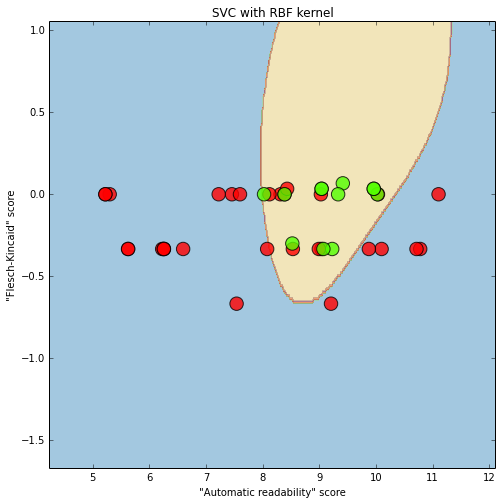

F: 0.70 (+/- 0.40)
Precision: 0.86 (+/- 0.21)
Recall: 0.63 (+/- 0.57)


In [93]:
# -------------- USE THIS ONE ---------------

#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html



import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# # import some data to play with
# iris = datasets.load_iris()
# X = iris.data[:, :2]  # we only take the first two features. We could
#                       # avoid this ugly slicing by using a two-dim dataset
# y = iris.target

X = np.array([training.fk_score,training['winning_w']]).T
y = np.array(training.score)

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 22  # SVM regularization param'auto'
clf = svm.SVC(kernel='rbf', gamma=0.4, C=C, class_weight='auto').fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
title = 'SVC with RBF kernel'

Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.prism, alpha = 0.8, s=180)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('"Automatic readability" score')
plt.ylabel('"Flesch-Kincaid" score')
plt.title(title)
fig.set_size_inches(8,8)

plt.show()

from sklearn import cross_validation
scoresF = cross_validation.cross_val_score(clf, X, y, cv=3,scoring='f1')
scoresP = cross_validation.cross_val_score(clf, X, y, cv=3,scoring='precision')
scoresR = cross_validation.cross_val_score(clf, X, y, cv=3,scoring='recall')


print("F: %0.2f (+/- %0.2f)" % (scoresF.mean(), scoresF.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (scoresP.mean(), scoresP.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scoresR.mean(), scoresR.std() * 2))

<h1>
NEW BIGGER TRAINING SET
</h1>

In [ ]:
training

In [118]:

if asin in training.asin.values:
    print ("YEAH")

In [134]:
dfm.columns

Index([u'asin', u'title', u'imgUrl', u'relevant_asins', u'sales_rank'], dtype='object')

In [16]:
import MySQLdb as mdb
import sys
import nltk
import pandas as pd
from textstat.textstat import textstat
import copy
import numpy as np
import nltk
import string
from collections import Counter
from nltk.corpus import stopwords
import math 
import re
import nltk.stem.porter as porter

con1 = mdb.connect('localhost', 'insightUser', 'insight15', 'amazon_filtered_compact');
dfm = pd.read_sql('select * from final;', con=con1) 
con1.close()

In [17]:
dffiltered = dfm[dfm['nrevs_positive'] > 10]
dffiltered.shape

dffiltered.drop('index',axis=1, inplace = True)
dffiltered.drop('relevant_asins',axis=1, inplace = True)
dffiltered.drop('imgUrl',axis=1, inplace = True)

dffiltered


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ValueError: labels ['relevant_asins'] not contained in axis

In [64]:
dffiltered.drop('ar_score',axis=1, inplace = True)
dffiltered.drop('fk_score',axis=1, inplace = True)
#dffiltered.drop('nrevs_positive',axis=1, inplace = True)

dffiltered.drop('avg_rating',axis=1, inplace = True)
dffiltered.drop('adv_w',axis=1, inplace = True)
dffiltered.drop('intro_w',axis=1, inplace = True)
dffiltered.drop('winning_w',axis=1, inplace = True)

dffiltered['true_class']=0


ValueError: labels ['ar_score'] not contained in axis

In [50]:
dfm['true_class']=0
#dfm.drop('imgUrl',axis=1, inplace = True)
dfm['link']=''
amazon_base = 'http://www.amazon.com/dp/'

for index,row in dfm.iterrows():
    asin = row.asin
    url = amazon_base+asin
    dfm.loc[index,'link'] = url
    if asin in training.asin.values:
        score = training[training.asin==asin]['score'].values[0]
        dfm.loc[index,'true_class'] = score

In [55]:
dffiltered['link']=''
amazon_base = 'http://www.amazon.com/dp/'

for index,row in dffiltered.iterrows():
    asin = row.asin
    url = amazon_base+asin
    dffiltered.loc[index,'link'] = url
    if asin in training.asin.values:
        score = training[training.asin==asin]['score'].values[0]
        dffiltered.loc[index,'true_class'] = score

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [ ]:
dffiltered.to_csv('training_set_3.csv')

<h1>
<font color="green">
Learn on the new training set
</font>
</h1>

In [13]:
import MySQLdb as mdb
import sys
import nltk
import pandas as pd
from textstat.textstat import textstat
import copy
import numpy as np
import nltk
import string
from collections import Counter
from nltk.corpus import stopwords
import math 
import re
import nltk.stem.porter as porter

def stem_words(words):
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in words:
        stemmed.append(stemmer.stem(item))
    return stemmed

def get_stemmed_set(text):
    '''http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html'''
    filtered = get_filtered_counter(text)
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))
    return set(stemmed)

def get_word_dict(text,keyset):
    keywd={}
    for keyword in keyset:
        keywd[keyword] = 0
    
    stemmed_text = get_stemmed_set(text)
    for word in stemmed_text:
        if word in keywd:
            keywd[word]+=1.
    return keywd

def count_keywords(indict):
    return sum(indict[key] for key in indict)


def build_vectors(counter1, counter2):
    all_items = set(counter1.keys()).union(set(counter2.keys()))
    vector1 = [counter1[k] for k in all_items]
    vector2 = [counter2[k] for k in all_items]
    return vector1, vector2

def normalized_product(v1, v2):
    dot_product = sum(n1 * n2 for n1, n2 in zip(v1, v2) )
    magnitude1 = math.sqrt(sum(n ** 2 for n in v1))
    magnitude2 = math.sqrt(sum(n ** 2 for n in v2))
    return dot_product / (magnitude1 * magnitude2)

def get_filtered_counter(text):
    '''http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html'''
    lowers = text.lower()
    #remove the punctuation using the character deletion step of translate
    #no_punctuation = lowers.translate(dict.fromkeys(string.punctuation)) # -- TODOlowers.translate(string.punctuation)
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    no_punctuation = regex.sub('', lowers)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    return Counter(tokens)

def get_filtered_stemmed_counter(text):
    '''http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html'''
    filtered = get_filtered_counter(text)
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))
    return Counter(stemmed)

def filtered_cosine_similarity(text1,text2):
    c1 = get_filtered_stemmed_counter(text1)
    c2 = get_filtered_stemmed_counter(text2)
    
    v1,v2 = build_vectors(c1, c2)
    return normalized_product(v1, v2)

In [34]:
training = pd.DataFrame.from_csv('training_set_3_filtered.csv')
training.drop('link',axis=1,inplace = True)

training


,asin,title,true_class,inferred_class,nrevs,nrevs_positive
240,0070350485,AnIntroductionToMechanics,2,2,33,25
296,0070692580,SchaumsOutlineofLagrangianDynamics,2,2,16,11
616,0073380571,FundamentalsofElectricCircuits,2,2,24,14
903,0130305529,OnLisp:AdvancedTechniquesforCommonLisp,2,2,12,11
920,0130457949,DifferentialEquationsandLinearAlgebra(3rdEdition),2,1,18,11
950,0130673897,NonlinearSystems(3rdEdition),2,2,12,12
951,0130652431,AppliedPartialDifferentialEquations(4thEdition),2,2,23,15
1055,013149726X,SolidStateElectronicDevices(6thEdition),2,2,19,12
1384,0136019692,FeedbackControlofDynamicSystems(6thEdition),2,1,25,13
1466,0138147574,SignalsandSystems(2ndEdition),2,2,56,36


In [42]:
adv_words = ['modern',
             'fundamentals',
             'complex',
             'frontier',
             'analysis',
             'principles'
            ]

intro_words = ['introduction',
               'laws',
               'elementary',
               'engin',
               'basic'
               'nature',
               'quest',
               'god',
               'college',
               'understanding',
               'essentials',
               'art',
               'starting',
               'easy'
              ]

adv_words_orig = ['modern',
             'fundamentals',
             'complex',
             'frontier',
             'analysis',
             'principles'
            ]

intro_words_orig = ['introduction',
               'laws',
               'elementary',
               'engin',
               'basic'
               'nature',
               'quest',
               'god'
              ]

adv_w = stem_words(adv_words)
intro_w = stem_words(intro_words)

# --- create classifier and use ----
# ---- set 1 - 3 classes, set 2 - 2 classes -----------------
#training = pd.DataFrame.from_csv('training_set_2.csv')
training = training.reset_index()
high_score_treshold = 4.
# training['nrevs'] = 0.
# training['nrevs_positive'] = 0
# training['title'] = ''

training['ar_score'] = 0.
training['fk_score'] = 0.
training['avg_rating'] = 0



# # --------------- fill titles -------------------
# for asin in training.asin:
#     title = dfm.title[dfm.asin==asin].values
#     indx = training[training.asin == asin].index
#     training.loc[indx,'title'] = title
    
    

# ----------FILL  THE TRAINING WEIGHTS --------
for index, row in training.iterrows():
    asin = row.asin
    df = dfr[dfr.asin==asin]
    
    revs = df[df.overall_score >= high_score_treshold].review_text
    revs_all = df.review_text
    nrevs = df.shape[0]

    #nrevs_positive = revs.shape[0]

    avg_rating = 0
    avg_rating = sum(df['overall_score'].values)/nrevs
    
    score01 = 0.
    score02 = 0.
    scores1_count = 0
    scores2_count = 0
    debug_failed_count = 0
    
    for rev in revs: 
        try:
            #a number that approximates the grade level needed to comprehend the text.
            score1 = textstat.automated_readability_index(rev)
            score01 += score1
            scores1_count +=1
        except: debug_failed_count +=1
            
        try: 
            #flesch_reading_ease  https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
            score2 = textstat.flesch_kincaid_grade(rev)
            score02 += score2
            scores2_count +=1
        except: debug_failed_count +=1
            
    if scores1_count > 0:
        score01 /= scores1_count
        
    if scores2_count > 0:
        score02 /= scores2_count
        
    indx = training[training.asin == asin].index
    training.loc[indx,'ar_score'] = score01
    training.loc[indx,'fk_score'] = score02
#     training.loc[indx,'nrevs'] = int(nrevs)
#     training.loc[indx,'nrevs_positive'] = nrevs_positive 
    training.loc[indx,'avg_rating'] = round(avg_rating,1) 

In [39]:
training['adv_w'] = 0
training['intro_w'] = 0
training['winning_w'] = 0

for indx, row in training.iterrows():
    asin = row.asin
    title = dfm[dfm.asin==asin].title.values[0]
    training.loc[indx,'title'] = title

    wd_a = get_word_dict(title,adv_w)
    wd_i = get_word_dict(title,intro_w)
    print wd_a
    wa_count = count_keywords(wd_a)
    wi_count = count_keywords(wd_i)
    
    print wa_count, wi_count

    indx = training[training.asin==asin].index

    training.loc[indx,'adv_w'] = wa_count
    training.loc[indx,'intro_w'] = wi_count
    
    scale = 10
    training.loc[indx,'winning_w'] = (wa_count - scale * wi_count)/30
    
# training.drop('level_0',inplace = True, axis = 1)
# training.drop('index',inplace = True, axis = 1)
# training
# training=training.sort('true_class', reverse = True)

# training

{u'analysi': 0, u'frontier': 0, u'modern': 0, u'complex': 0, u'fundament': 0, u'principl': 0}
0 1.0
{u'analysi': 0, u'frontier': 0, u'modern': 0, u'complex': 0, u'fundament': 0, u'principl': 0}
0 0
{u'analysi': 0, u'frontier': 0, u'modern': 0, u'complex': 0, u'fundament': 1.0, u'principl': 0}
1.0 0
{u'analysi': 0, u'frontier': 0, u'modern': 0, u'complex': 0, u'fundament': 0, u'principl': 0}
0 0
{u'analysi': 0, u'frontier': 0, u'modern': 0, u'complex': 0, u'fundament': 0, u'principl': 0}
0 0
{u'analysi': 0, u'frontier': 0, u'modern': 0, u'complex': 0, u'fundament': 0, u'principl': 0}
0 0
{u'analysi': 0, u'frontier': 0, u'modern': 0, u'complex': 0, u'fundament': 0, u'principl': 0}
0 0
{u'analysi': 0, u'frontier': 0, u'modern': 0, u'complex': 0, u'fundament': 0, u'principl': 0}
0 0
{u'analysi': 0, u'frontier': 0, u'modern': 0, u'complex': 0, u'fundament': 0, u'principl': 0}
0 0
{u'analysi': 0, u'frontier': 0, u'modern': 0, u'complex': 0, u'fundament': 0, u'principl': 0}
0 0
{u'analysi': 0

In [ ]:
training

In [103]:
training.to_csv('training_set3_processed.csv')

In [140]:
training = pd.read_csv('training_set3_processed.csv')
training.sort('true_class', inplace = True)

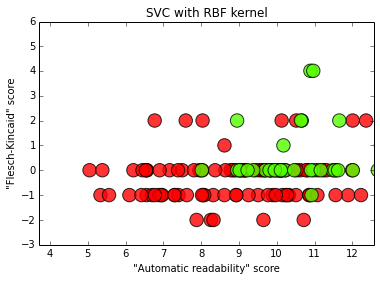

In [141]:
# ------- rescale traiing on words ----------
for indx, row in training.iterrows():
    
    wa_count = row['adv_w']
    
    wi_count = row['intro_w']
    
    scale = 1
    training.loc[indx,'winning_w'] = (2*wa_count -  wi_count)

X = np.array([training.ar_score,training['winning_w']]).T
#X = np.array([training.ar_score,training.fk_score]).T
y = np.array(training.true_class)  
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5

# Plot also the training points
plt.scatter(X[:,0], X[:, 1], c=y, cmap=plt.cm.prism, alpha = 0.8, s=180)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('"Automatic readability" score')
plt.ylabel('"Flesch-Kincaid" score')
plt.title(title)
fig.set_size_inches(8,8)

plt.show()


In [ ]:
chk = training[training.true_class==2]

chk.sort('fk_score')

In [144]:
# -------------- GRID SEARCH IN 3D ---------------

#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from __future__ import print_function

#X = np.array([training.fk_score,training.ar_score,training['winning_w']]).T
X = np.array([training.fk_score,training.ar_score,training['winning_w']]).T
y = np.array(training.true_class)

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.2,0.4,0.5,0.6,0.7,0.8, 1, 1.2 ],
                     'C': [0.2,0.4,0.5,0.6,0.7,0.8, 1, 1.2 ], 'class_weight': ['auto']}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()



# Tuning hyper-parameters for f1

Best parameters set found on development set:

SVC(C=0.2, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=1.2, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

Grid scores on development set:

0.633 (+/-0.072) for {'kernel': 'rbf', 'C': 0.2, 'gamma': 0.2, 'class_weight': 'auto'}
0.736 (+/-0.056) for {'kernel': 'rbf', 'C': 0.2, 'gamma': 0.4, 'class_weight': 'auto'}
0.768 (+/-0.033) for {'kernel': 'rbf', 'C': 0.2, 'gamma': 0.5, 'class_weight': 'auto'}
0.808 (+/-0.040) for {'kernel': 'rbf', 'C': 0.2, 'gamma': 0.6, 'class_weight': 'auto'}
0.803 (+/-0.037) for {'kernel': 'rbf', 'C': 0.2, 'gamma': 0.7, 'class_weight': 'auto'}
0.795 (+/-0.038) for {'kernel': 'rbf', 'C': 0.2, 'gamma': 0.8, 'class_weight': 'auto'}
0.805 (+/-0.041) for {'kernel': 'rbf', 'C': 0.2, 'gamma': 1, 'class_weight': 'auto'}
0.831 (+/-0.026) for {'kernel': 'rbf', 'C': 0.2, 'gamma': 1.2, 'class_weight': 'auto'}


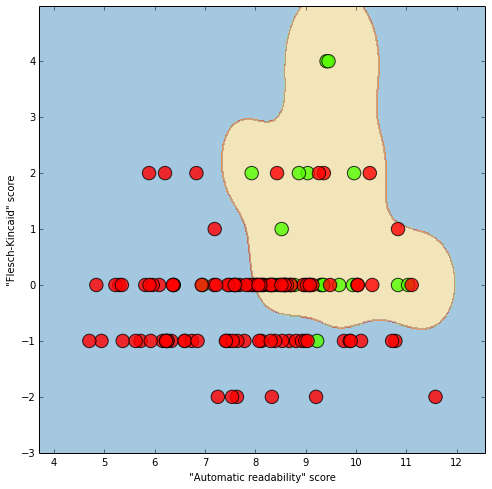

F: 0.73 (+/- 0.08)
Precision: 0.86 (+/- 0.01)
Recall: 0.64 (+/- 0.12)


In [214]:
# -------------- USE THIS ONE ---------------

#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

training.sort('true_class', inplace = True, ascending = False)

X = np.array([training.fk_score,training.ar_score,training['winning_w']]).T
y = np.array(training.true_class)
h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 0.4 # SVM regularization param'auto'
gamma = 1.
clf = svm.SVC(kernel='rbf', gamma=gamma, C=C, class_weight='auto').fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 2].min() - 1, X[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
title = '  '

Z = clf.predict(np.c_[xx.ravel(),xx.ravel()+1.315,yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

# Plot also the training points
plt.scatter(X[:,0], X[:, 2], c=y, cmap=plt.cm.prism, alpha = 0.8, s=180)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('"Automatic readability" score')
plt.ylabel('"Flesch-Kincaid" score')
plt.title(title)
fig.set_size_inches(8,8)

plt.show()

from sklearn import cross_validation
scoresF = cross_validation.cross_val_score(clf, X, y, cv=3,scoring='f1')
scoresP = cross_validation.cross_val_score(clf, X, y, cv=3,scoring='precision')
scoresR = cross_validation.cross_val_score(clf, X, y, cv=3,scoring='recall')


print("F: %0.2f (+/- %0.2f)" % (scoresF.mean(), scoresF.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (scoresP.mean(), scoresP.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scoresR.mean(), scoresR.std() * 2))

-1.3158314442482089

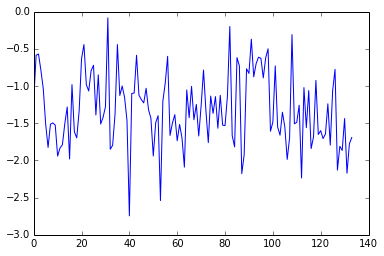

In [131]:
XX = np.array([training.fk_score-training.ar_score]).T

plt.plot(XX)

np.mean(XX)




In [139]:
training.sort('winning_w')

,Unnamed: 0,index,asin,title,true_class,inferred_class,nrevs,nrevs_positive,adv_w,intro_w,winning_w,ar_score,fk_score,avg_rating
85,85,1763,0199572194,The Laws of Thermodynamics: A Very Short Intro...,1,1,32,30,0,2,-2,10.713333,9.206667,4.6
32,32,1,0006970117,Materials Science and Engineering: An Introduc...,1,1,12,11,0,2,-2,8.254545,7.636364,4.2
95,95,1880,0201824981,Introduction to Nuclear Engineering (3rd Edition),1,1,25,15,0,2,-2,8.326667,7.540000,3.5
64,64,798,0080966659,"Engineering Materials 1, Fourth Edition: An In...",1,1,22,18,0,2,-2,13.755556,11.577778,4.2
68,68,1048,0131481932,Introduction to Environmental Engineering and ...,1,1,21,17,0,2,-2,9.647059,8.329412,3.9
53,53,566,0073104450,Introduction to Chemical Engineering Thermodyn...,1,1,24,14,0,2,-2,7.878571,7.257143,3.6
101,101,2025,0262560038,The Character of Physical Law (Messenger Lectu...,1,2,33,30,0,1,-1,11.556667,9.760000,4.5
129,129,594,0073376337,Statistics for Engineers and Scientists,1,1,13,11,0,1,-1,7.290909,6.163636,4.2
36,36,114,0060539801,"Essential Manners for Men: What to Do, When to...",1,2,29,22,0,1,-1,10.240909,8.672727,3.9
126,126,540,0072467509,Introduction to Computing Systems: From bits ;...,1,2,21,16,0,1,-1,9.768750,8.306250,4.1


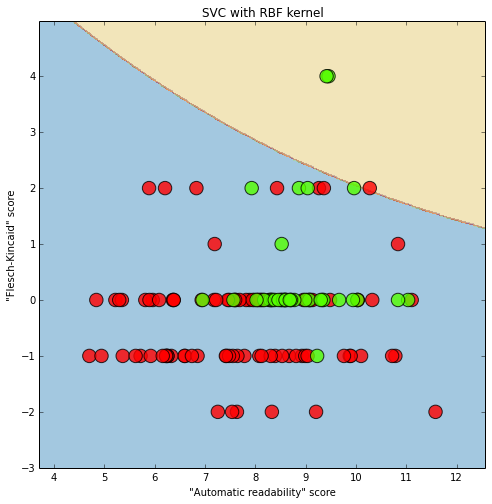

F: 0.76 (+/- 0.20)
Precision: 0.89 (+/- 0.02)
Recall: 0.68 (+/- 0.30)


In [152]:
# -------------- TRY POLYNOMIAL ---------------

#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# # import some data to play with
# iris = datasets.load_iris()
# X = iris.data[:, :2]  # we only take the first two features. We could
#                       # avoid this ugly slicing by using a two-dim dataset
# y = iris.target

X = np.array([training.fk_score,training.ar_score,training['winning_w']]).T
#X = np.array([training.ar_score,training.fk_score]).T
y = np.array(training.true_class)

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 0.4 # SVM regularization param'auto'
gamma = 1
clf = svm.SVC(kernel='rbf', gamma=gamma, C=C, class_weight='auto').fit(X, y)

Cpoly = 1
poly_svc = svm.SVC(kernel='poly', degree=2, C=Cpoly).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 2].min() - 1, X[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = poly_svc.predict(np.c_[xx.ravel(),xx.ravel()+1.315,yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

# Plot also the training points
plt.scatter(X[:,0], X[:, 2], c=y, cmap=plt.cm.prism, alpha = 0.8, s=180)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('"Automatic readability" score')
plt.ylabel('"Flesch-Kincaid" score')
plt.title(title)
fig.set_size_inches(8,8)

plt.show()

from sklearn import cross_validation
scoresF = cross_validation.cross_val_score(clf, X, y, cv=3,scoring='f1')
scoresP = cross_validation.cross_val_score(clf, X, y, cv=3,scoring='precision')
scoresR = cross_validation.cross_val_score(clf, X, y, cv=3,scoring='recall')


print("F: %0.2f (+/- %0.2f)" % (scoresF.mean(), scoresF.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (scoresP.mean(), scoresP.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scoresR.mean(), scoresR.std() * 2))